## Urban Sounds Classification  
### Neural Net,  AdaBoost, Bagging

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skflow

from collections import Counter
from sklearn import datasets, metrics, cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

In [2]:
def plotHeatmap(y_actual, y_pred, y_labels, printCF=False):
    y_counts = np.asarray(Counter(y_actual).values())
    confMat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    if printCF:
        print(confMat)
    confMatNorm = np.true_divide(confMat, y_counts)
    
    fig, ax = plt.subplots()
    heatmap = ax.pcolor(confMatNorm, cmap=plt.cm.jet, vmin=0, vmax=1)

    # locate ticks
    ax.set_xticks(np.arange(confMatNorm.shape[0])+0.5, minor=False)
    ax.set_yticks(np.arange(confMatNorm.shape[1])+0.5, minor=False)

    # move x ticks to top
    ax.invert_yaxis()
    ax.xaxis.tick_top()

    ax.set_xticklabels(y_labels, minor=False, rotation='vertical')
    ax.set_yticklabels(y_labels, minor=False)

    #ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Actual Class')

    plt.show()

In [3]:
# Import Pre-Processed Wav File Data Set
wavData = pd.read_csv('feature_quant_new.csv')

# Remove Empty Rows
wavData = wavData[-np.isnan(wavData['mean'])]

In [4]:
print len(wavData)
print wavData[0:2]

530
   Unnamed: 0     kurt7      min11       med4    skew13    power6     kurt4  \
0  100032.wav -0.070401 -18.675434 -22.182070  0.117793  0.049451 -0.312771   
1  100263.wav  0.766502 -53.592658 -38.231859  0.062134  0.145623  0.297177   

       std3     skew9     med12    ...          max7       min6    power2  \
0  7.780253 -0.845639 -0.121202    ...     25.780917 -74.076196  0.218719   
1  4.916808 -0.247002 -5.770335    ...     82.847933 -82.382565  0.077798   

        std6    power4       min8      max13    kurt11    power9     std12  
0  16.140037  0.286047 -27.837698   9.329147  0.406636  0.007275  6.568384  
1  10.379953  0.112095 -56.489494  43.924134  1.990391  0.095986  9.269602  

[2 rows x 107 columns]


In [5]:
# create feature (only) array by dropping index and class columns
feat = list(wavData.columns)
feat.remove('class')
feat.remove('Unnamed: 0')

In [6]:
# convert class labels to numeric category 0-9
le = LabelEncoder()
y = wavData.loc[:,'class']
y = le.fit_transform(y)
y_labels = list(le.classes_)

In [7]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(wavData.loc[:,feat], y, \
                                                    test_size=0.3, random_state=0)
X_train.shape

(371, 105)

In [8]:
# scale data according to training set distribution
sc = StandardScaler()
sc=sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

### Neural Network  
Results with 10000 steps with learning rates 0.1, 0.01, 0.001:  
  
5 hidden units - 0.266, 0.239  
7 hidden units - ****0.348****, 0.266 (20000 steps, 0.1 learning rate: 0.288) --> ****0.491**** with new features, haven't tried other options yet  
10 hidden units - 0.266, 0.304  
30 hidden units - 0.250, 0.299  
50 hidden units - 0.277, 0.315  
100 hidden units - 0.250, 0.321 (20000 steps, 0.01 learning rate: 0.310)  
  
[5,10,5] hidden units - 0.254, 0.310 (20000 steps, 0.01 learning rate: 0.310)  
[10,20,10] hidden units - 0.293, 0.304 (20000 steps, 0.01 learning rate: 0.293)  
[30,60,30] hidden units - 0.304, 0.261 (20000 steps, 0.1 learning rate: 0.310)  
[50,100,50] hidden units - 0.283, 0.283  

In [9]:
classifier = skflow.TensorFlowDNNClassifier(hidden_units=[7], n_classes=10, steps=10000, \
                                            tf_random_seed=0, learning_rate = 0.1)
classifier.fit(X_train_std, y_train)
score = metrics.accuracy_score(y_test, classifier.predict(X_test_std))
print("Accuracy: %f" % score)

Step #100, epoch #8, avg. train loss: 1.59363
Step #200, epoch #16, avg. train loss: 1.03778
Step #300, epoch #25, avg. train loss: 0.83879
Step #400, epoch #33, avg. train loss: 0.70517
Step #500, epoch #41, avg. train loss: 0.62019
Step #600, epoch #50, avg. train loss: 0.52463
Step #700, epoch #58, avg. train loss: 0.46059
Step #800, epoch #66, avg. train loss: 0.40397
Step #900, epoch #75, avg. train loss: 0.37078
Step #1000, epoch #83, avg. train loss: 0.33284
Step #1100, epoch #91, avg. train loss: 0.30751
Step #1200, epoch #100, avg. train loss: 0.28211
Step #1300, epoch #108, avg. train loss: 0.25970
Step #1400, epoch #116, avg. train loss: 0.24426
Step #1500, epoch #125, avg. train loss: 0.22318
Step #1600, epoch #133, avg. train loss: 0.20915
Step #1700, epoch #141, avg. train loss: 0.19328
Step #1800, epoch #150, avg. train loss: 0.18592
Step #1900, epoch #158, avg. train loss: 0.17454
Step #2000, epoch #166, avg. train loss: 0.16330
Step #2100, epoch #175, avg. train loss: 

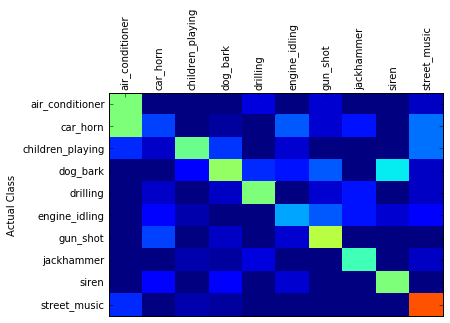

In [10]:
plotHeatmap(y_test, classifier.predict(X_test_std), y_labels)

### AdaBoost Classifier  
Decision tree depth with learning rate 0.1 and 500, 1000, 2000, 5000 estimators:  
1 - 0.310  
2 - 0.299  
4 - 0.342, 0.353, 0.359  
6 - 0.386, 0.380, ****0.391****, 0.386 --> ****0.572**** with new features, haven't tried other options yet  
8 - 0.353, 0.375, 0.370, 0.359  
10 - 0.304  

In [11]:
tree = DecisionTreeClassifier(criterion='entropy',
                             max_depth=6)
ada = AdaBoostClassifier(base_estimator=tree,
                        n_estimators=2000,
                        learning_rate=0.1,
                        random_state=0)
ada = ada.fit(X_train_std, y_train)
y_train_pred = ada.predict(X_train_std)
y_test_pred = ada.predict(X_test_std)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('AdaBoost train/test accuracies %.3f/%.3f'
     % (ada_train, ada_test))

AdaBoost train/test accuracies 1.000/0.572


[[ 1  1  1  0  1  2  0  0  0  0]
 [ 0 10  1  3  0  2  0  0  0  0]
 [ 0  1 16  8  0  0  0  0  0  0]
 [ 0  0  2 32  0  0  0  0  0  0]
 [ 0  0  1  4  6  0  0  0  0  1]
 [ 0  3  0  3  0  7  0  0  0  1]
 [ 0  1  0  3  0  0 10  0  0  0]
 [ 0  0  1  2  2  0  0  1  0  1]
 [ 0  0  1  9  0  0  0  0  3  1]
 [ 0  2  5  2  1  0  0  0  2  5]]


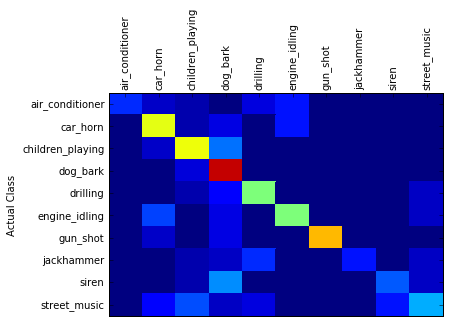

In [12]:
plotHeatmap(y_test, y_test_pred, y_labels, printCF=True)

### Bagging Classifier  
Decision tree depth none, varying estimators, max samples, max features:  
estimators, max samples, max features, accuracy  
500, 1.0, 1.0, 0.375  
1000, 1.0, 1.0, 0.391  
  
500, 0.7, 0.7, 0.440  
1000, 0.7, 0.7, 0.429  
2000, 0.7, 0.7, 0.424  
  
500, 0.5, 0.5, 0.435  
1000, 0.5, 0.5, 0.440  
2000, 0.5, 0.5, 0.451  
  
1000, 0.7, 0.5, ****0.467**** --> ****0.597**** with new features, haven't tried other options yet  
1000, 0.8, 0.5, ****0.467****  

2000, 0.7, 0.5, 0.457  
1000, 0.7, 0.5, 0.462  

In [13]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None)
bag = BaggingClassifier(base_estimator=tree,n_estimators=2000,max_samples=0.7,max_features=0.5,
                       bootstrap=True,bootstrap_features=False,n_jobs=1, random_state=1)

bag = bag.fit(X_train_std, y_train)
y_train_pred = bag.predict(X_train_std)
y_test_pred = bag.predict(X_test_std)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('Bagging train/test accuracies %.3f/%.3f'
     % (bag_train, bag_test))

Bagging train/test accuracies 1.000/0.597


[[ 2  0  2  0  0  2  0  0  0  0]
 [ 1  6  2  1  0  2  2  0  0  2]
 [ 0  2 16  5  0  0  0  0  1  1]
 [ 0  0  3 29  0  0  1  0  0  1]
 [ 0  1  1  1  8  0  0  0  0  1]
 [ 0  6  0  0  0  6  1  0  0  1]
 [ 0  1  0  2  0  0 11  0  0  0]
 [ 0  1  0  2  2  0  0  1  0  1]
 [ 0  0  0  9  1  0  0  0  4  0]
 [ 0  1  2  1  0  1  0  0  0 12]]


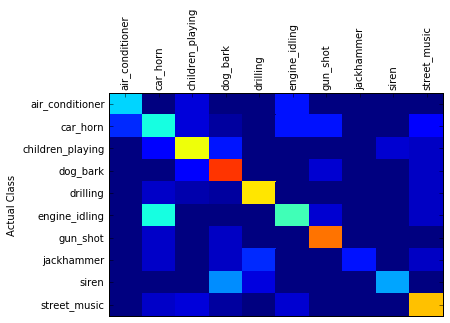

In [14]:
plotHeatmap(y_test, y_test_pred, y_labels, printCF=True)